Dropout regularization

In [1]:
import numpy as np
import pandas as pd
import torch 
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from torch import nn
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import torch.utils.data as td
from scipy.stats import linregress

In [2]:
data = pd.read_csv('D:\OneDrive\MLprac\heart_disease_prediction.csv')
data.head()

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,No,16.60,Yes,No,No,3.0,30.0,No,Female,55-59,White,Yes,Yes,Very good,5.0,Yes,No,Yes
1,No,20.34,No,No,Yes,0.0,0.0,No,Female,80 or older,White,No,Yes,Very good,7.0,No,No,No
2,No,26.58,Yes,No,No,20.0,30.0,No,Male,65-69,White,Yes,Yes,Fair,8.0,Yes,No,No
3,No,24.21,No,No,No,0.0,0.0,No,Female,75-79,White,No,No,Good,6.0,No,No,Yes
4,No,23.71,No,No,No,28.0,0.0,Yes,Female,40-44,White,No,Yes,Very good,8.0,No,No,No


In [3]:
catcols = ['Smoking', 'AlcoholDrinking', 'Stroke',
        'DiffWalking', 'Sex', 'AgeCategory',
       'Race', 'Diabetic', 'PhysicalActivity', 'GenHealth', 
       'Asthma', 'KidneyDisease', 'SkinCancer']
data = pd.get_dummies(data, columns = catcols)
data['HeartDisease'] = LabelBinarizer().fit_transform(data['HeartDisease'])

In [4]:
x_train,x_test,y_train,y_test = train_test_split(data.drop('HeartDisease', axis = 1), data['HeartDisease'], test_size= 0.2, shuffle= True, stratify= data['HeartDisease'], random_state= 777)
x_train,x_val,y_train,y_val = train_test_split(x_train, y_train, test_size= 0.2, shuffle= True, stratify= y_train, random_state= 777)


In [5]:
data.head()

,HeartDisease,BMI,PhysicalHealth,MentalHealth,SleepTime,Smoking_No,Smoking_Yes,AlcoholDrinking_No,AlcoholDrinking_Yes,Stroke_No,...,GenHealth_Fair,GenHealth_Good,GenHealth_Poor,GenHealth_Very good,Asthma_No,Asthma_Yes,KidneyDisease_No,KidneyDisease_Yes,SkinCancer_No,SkinCancer_Yes
0,0,16.60,3.0,30.0,5.0,0,1,1,0,1,...,0,0,0,1,0,1,1,0,0,1
1,0,20.34,0.0,0.0,7.0,1,0,1,0,0,...,0,0,0,1,1,0,1,0,1,0
2,0,26.58,20.0,30.0,8.0,0,1,1,0,1,...,1,0,0,0,0,1,1,0,1,0
3,0,24.21,0.0,0.0,6.0,1,0,1,0,1,...,0,1,0,0,1,0,1,0,0,1
4,0,23.71,28.0,0.0,8.0,1,0,1,0,1,...,0,0,0,1,1,0,1,0,1,0


In [6]:
# building network
class HeartDiseaseNet(nn.Module):
    def __init__(self):
        super().__init__()
        hidden1 = nn.Linear(50,1024)
        relu1 = nn.ReLU()
        dropout1 = nn.Dropout(p = 0.2)
        hidden2 = nn.Linear(1024,1024)
        relu2 = nn.ReLU()
        dropout2 = nn.Dropout(p = 0.2)
        hidden3 = nn.Linear(1024,1024)
        relu3 = nn.ReLU()
        hidden4 = nn.Linear(1024,1)
        sigmoid = nn.Sigmoid()
        self.model = nn.Sequential(hidden1,relu1,dropout1, hidden2,relu2,dropout2,hidden3,relu3,hidden4, sigmoid)
    def forward(self,x):
        return self.model(x)

class HeartDiseaseDataSet(td.Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
    def __len__(self):
        return self.x.shape[0]
    def __getitem__(self,idx):
        return (self.x.iloc[idx:idx+1,:].values.ravel(), self.y[idx:idx+1].values)

class EarlyStopping:
    def __init__(self,e_hist,model,window_size = 10):
        self.hist = e_hist
        self.model = model
        self.window_size = window_size
        self.state_dict = []

    def stop(self):
        if len(self.hist['val_loss']) < self.window_size:
            self.state_dict.append(self.model.state_dict())
            return False
        self.state_dict.append(self.model.state_dict())
        window = self.hist['val_loss'][len(self.hist['val_loss']) - self.window_size:]
        slope = linregress(x = range(1,self.window_size + 1), y = window).slope
        if slope > 0 :
            self.model.load_state_dict(self.state_dict[len(self.hist['val_loss']) - 2])
            return True
        else:
            return False


In [7]:
#preparing for training  
epochs = 250 
batch_size = 32 
batch_count = x_train.shape[0]/batch_size if x_train.shape[0]%batch_size == 0 else (x_train.shape[0]//batch_size) + 1
learning_rate = 0.001
loss_fn = nn.BCELoss()
model = HeartDiseaseNet()
model = model.to(device = 'cuda')
optim = torch.optim.SGD(model.parameters(),lr = learning_rate)
traindata = HeartDiseaseDataSet(x_train, y_train)
train_data_loader = td.DataLoader(traindata,batch_size= batch_size, shuffle = True)
epoc_hist = {'train_acc':[],'train_loss':[],'val_acc': [], 'val_loss': []}
early_stop = EarlyStopping(epoc_hist, model)

In [8]:
#training loop
for epoch in range(0,epochs): #epoch loop
    batch_acc = []
    batch_loss = []
    for idx, (x_batch, y_batch) in enumerate(train_data_loader): # batch loop
        probs = model.forward(x_batch.to(dtype = torch.float32, device = 'cuda'))
        loss = loss_fn(probs, y_batch.to(dtype = torch.float32, device = 'cuda'))
        optim.zero_grad() # resets the optimizer
        loss.backward() # doing first derivative (calc gradients)
        optim.step() # adjusting weights
        batch_loss.append(loss.item())
        batch_acc.append(accuracy_score(y_batch.cpu().detach().numpy(),[1 if prob > 0.5 else 0 for prob in probs.cpu().detach().numpy()]))
        #if idx%20 == 0:
            #print(f'batch {idx} loss: {batch_loss[-1]}, accuracy: {batch_acc[-1]}')
    epoc_hist['train_acc'].append(np.average(batch_acc))  
    epoc_hist['train_loss'].append(np.average(batch_loss))
    probs_val = model.forward(torch.from_numpy(x_val.values).to(dtype=torch.float32, device= 'cuda'))
    loss_val = loss_fn(probs_val, torch.from_numpy(y_val.values.reshape(-1,1)).to(dtype=torch.float32, device= 'cuda'))  
    epoc_hist['val_acc'].append(accuracy_score(y_val,[1 if prob > 0.5 else 0 for prob in probs_val.cpu().detach().numpy()])) 
    epoc_hist['val_loss'].append(loss_val.item())
    print(f'e({epoch}): T({epoc_hist["train_loss"][-1]},{epoc_hist["train_acc"][-1]}), V({epoc_hist["val_loss"][-1]},{epoc_hist["val_acc"][-1]})')
    if early_stop.stop() == True:
        print(f'Stopping at epoch {epoch}')
        break

e(0): T(0.29182882861393256,0.9142753841686768), V(0.28646427392959595,0.914380081300813)
e(1): T(0.2809200249303638,0.9143919469757885), V(0.27868515253067017,0.9143996247654784)
e(2): T(0.27429323111735915,0.9143542560082194), V(0.2721761167049408,0.914282363977486)
e(3): T(0.268893566293021,0.9142272234878942), V(0.26608479022979736,0.9141846466541589)
e(4): T(0.264401054041247,0.914252350799607), V(0.26275014877319336,0.9143996247654784)
e(5): T(0.26008334302059777,0.9143423903332439), V(0.2578634023666382,0.9143409943714822)
e(6): T(0.25656720083975715,0.9143305246582687), V(0.2548902630805969,0.9143214509068167)
e(7): T(0.2537863875364767,0.9143493701420531), V(0.25169995427131653,0.914380081300813)
e(8): T(0.25193498225671807,0.9143633297596712), V(0.2506828010082245,0.9145559724828017)
e(9): T(0.25001655345557816,0.9146027372018225), V(0.2476670742034912,0.9142628205128205)
e(10): T(0.24818656017527385,0.9143640277405521), V(0.2489982396364212,0.9145950594121326)
e(11): T(0.246

<AxesSubplot:>

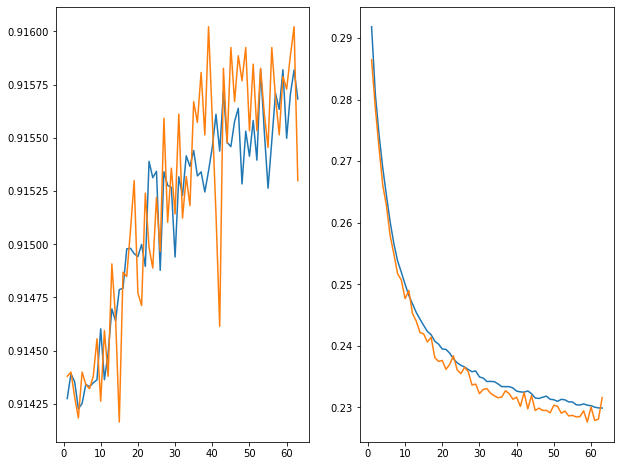

In [9]:
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (10,8))
sns.lineplot(x = range(1,len(epoc_hist['train_acc']) + 1), y = epoc_hist['train_acc'], ax = ax1)
sns.lineplot(x = range(1,len(epoc_hist['train_acc']) + 1), y = epoc_hist['val_acc'], ax = ax1)
sns.lineplot(x = range(1,len(epoc_hist['train_acc']) + 1), y = epoc_hist['train_loss'], ax = ax2)
sns.lineplot(x = range(1,len(epoc_hist['train_acc']) + 1), y = epoc_hist['val_loss'], ax = ax2)

In [10]:
with torch.no_grad():
    probs_test = model.forward(torch.from_numpy(x_test.values).to(dtype=torch.float32, device= 'cuda'))
    test_acc = accuracy_score(y_test,[1 if prob > 0.5 else 0 for prob in probs_test.cpu().detach().numpy()])
    print(f'test accuracy is {test_acc}')

test accuracy is 0.9150080520333339
